<a href="https://colab.research.google.com/github/Ogunfool/Maintenance-Planning-with-reinforcement-learning/blob/main/Maintenance_Planning_Environment_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Survival Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
! pip install reliability
! pip install lifelines

In [3]:
from lifelines import KaplanMeierFitter,WeibullFitter
from numpy.random import Generator as gen
from numpy.random import PCG64 as pcg

In [4]:
# Data Generation
from reliability.Datasets import system_growth
failure_times = system_growth().failures
censorship = np.ones_like(failure_times)

In [5]:
data = np.array([failure_times,censorship])
data = data.transpose()
data.shape

(22, 2)

In [6]:
failure_times_a = np.array(failure_times)
failure_times_a.shape

(22,)

In [7]:
np.mean(failure_times_a)

220.33181818181814

In [8]:
np.std(failure_times_a)

176.7256049420931

In [9]:
# Generate Data for 2 other machines
array_rg = gen(pcg(365))
failure_times_b = array_rg.normal((np.mean(failure_times_a)), (np.std(failure_times_a)), size = (failure_times_a.shape))
failure_times_b = np.where(failure_times_b < 0, -failure_times_b, failure_times_b)
sum(failure_times_b < 0)

0

In [10]:
failure_times_b.shape

(22,)

In [11]:
# Data for machine 3
array_rg = gen(pcg(365))
failure_times_c = array_rg.normal((np.mean(failure_times_a)/2.17), 100, size = (failure_times_a.shape))
failure_times_c = np.where(failure_times_c < 0, -failure_times_c, failure_times_c)
sum(failure_times_c < 0)

0

In [12]:
failure_times_c.shape

(22,)

In [13]:
# Instantiate weibullfitter objects for all 3 machines
failures_a_wb = WeibullFitter()
failures_b_wb = WeibullFitter()
failures_c_wb = WeibullFitter()

In [14]:
# Fit all
failures_a_wb.fit(durations=failure_times_a, label='component_1')
failures_b_wb.fit(durations=failure_times_b, label='component_2')
failures_c_wb.fit(durations=failure_times_c, label='component_3')

<lifelines.WeibullFitter:"component_3", fitted with 22 total observations, 0 right-censored observations>

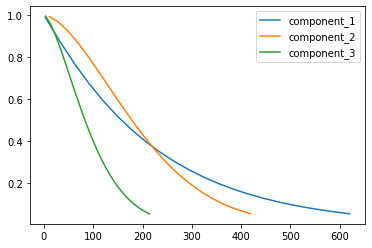

In [15]:
failures_a_wb.plot_survival_function(ci_show=False)
failures_b_wb.plot_survival_function(ci_show=False)
failures_c_wb.plot_survival_function(ci_show=False)
plt.show()

In [16]:
machine_failure_times = np.array([failures_a_wb,failures_b_wb,failures_c_wb])
machine_failure_times

array([<lifelines.WeibullFitter:"component_1", fitted with 22 total observations, 0 right-censored observations>,
       <lifelines.WeibullFitter:"component_2", fitted with 22 total observations, 0 right-censored observations>,
       <lifelines.WeibullFitter:"component_3", fitted with 22 total observations, 0 right-censored observations>],
      dtype=object)

In [17]:
print(failures_a_wb.median_survival_time_)
print(failures_b_wb.median_survival_time_)
print(failures_c_wb.median_survival_time_)

157.22900074291118
178.33931322824708
83.18437645779817


In [18]:
no_of_machine = 3
no_of_state = 5
# copied from iterative_policy_evaluation
def get_transition_probs(machine_failure_times):
  ### define transition probabilities and planner ###
  # the key is (s, a, s'), the value is the probability
  # that is, transition_probs[(s, a, s')] = p(s' | s, a)
  # any key NOT present will considered to be impossible (i.e. probability 0)
  transition_probs = {}

  # to reduce the dimensionality of the dictionary, we'll use deterministic
  # rewards, r(s, a, s')
  # note: you could make it simpler by using r(s') since the reward doesn't
  # actually depend on (s, a)

# for m in range(1,(no_of_machine+1)):
  for i in range(3):
    for p in range(6):
      transition_probs[(i,p,'NM')] = machine_failure_times[i].predict(p*100)
          
  return transition_probs

In [34]:
transition_probs = get_transition_probs(machine_failure_times)

In [ ]:
transition_probs

In [28]:
# # AI-Based Maintenance Planner Environment
# import numpy as np

# # "NM" = No Maintenance, "PM" = Preventive Maintenance
# ACTION_SPACE = ('NM', 'PM')

# class Planner: # Environment for 3 machines
#   def __init__(self, start=(0,0,0)):
#     self.s = start

#   def set(self, rewards, actions):
#     # rewards should be a dict of: ("action"): r ("NM"): reward
#     # actions should be a dict of: (int): A (1): list of actions for all 3 machines
#     self.rewards = rewards
#     self.actions = actions

#   # Use to set next state to current state
#   def set_state(self, s):
#     self.s = tuple(s)

#   def current_state(self):
#     return (self.s)

#   def is_terminal(self):  #Takes tuple of states for all machines, Returns a boolean tuple
#     status = []
#     for t in range(3):
#       status.append(self.s[t] >= 5)
      
#     return(status)

#   def is_terminal_single(self, s):  # Takes single machine state, Returns a boolean 
#     return s >= 5

#   def reset(self):
#     # put agent back in start position
#     self.s = (0,0,0)
#     return (self.s)

#   def get_next_state(self,a):
#     # This answers: where would I end up if I perform action 'a' in state 's'?
#     s_next = [0,0,0]
#     for m in range(3):
#       # Check if state is terminal
#       # When in terminal state, the next state is independent of the action taken
#       if self.is_terminal_single(self.s[m]):
#         s_next[m] = 0
#         # Debugging tool
#         print("episode end:", m, self.s[m], s_next[m], a[m])
#       else:
#         print("Not terminal state:", m, self.s[m], s_next[m], a[m])
      
#       if a[m] == "NM":
#         if (self.is_terminal_single(self.s[m]) == 0):
#           s_next[m] = np.random.choice([self.s[m] + 1, 0], p=[transition_probs[m,self.s[m],a[m]], 1-transition_probs[m,self.s[m],a[m]]])
#           # Debugging 
#           print("Action is AM:", m, self.s[m], s_next[m], a[m])

#       if a[m] == "PM":
#         s_next[m] = 0
#         # Debugging
#         print("action is PM:", m, self.s[m], s_next[m], a[m])
    
#     # Set next state as new state
#     self.set_state(s_next)
#     return s_next

#   def act(self, a):
#     a_array = np.copy(a)
#     reward = np.zeros((3,))
#     # this answers: where would I end up if I perform action 'a' in state 's'?
#     s_next = np.zeros((3,))
#     for m in range(3):
#       # Check if state is terminal
#       if self.is_terminal_single(self.s[m]):
#         s_next[m] = 0
#         a_array[m] = "CM"

#       if a[m] == "NM":
#         if (self.is_terminal_single(self.s[m]) == 0):
#           s_next[m] = np.random.choice([self.s[m] + 1, 0], p=[transition_probs[m,self.s[m],a[m]], 1-transition_probs[m,self.s[m],a[m]]])
#           if s_next[m] == 0:
#             a_array[m] = "CM"
            

#       if a[m] == "PM":
#         s_next[m] = 0

#       # Collect reward for action taken on each machine
#       reward[m] = self.rewards[a_array[m]]

#     # Set next state as new state
#     self.set_state(s_next)
#     return reward.sum()

# def standard_planner():
#   # define a planner that describes the reward for arriving at each state
#   # and possible actions at each state
#   # s means start position
#   g = Planner()
#   rewards = {("NM"): 0, ("PM"): -100, ("CM"): -200}
#   actions = {
#     (0): ('NM', 'NM', 'NM'),
#     (1): ('PM', 'PM', 'PM'),
#     (2): ('NM', 'NM', 'PM'),
#     (3): ('NM', 'PM', 'NM'),
#     (4): ('PM', 'NM', 'NM'),
#     (5): ('PM', 'PM', 'NM'),
#     (6): ('PM', 'NM', 'PM'),
#     (7): ('NM', 'PM', 'PM'),
#   }
#   g.set(rewards, actions)
#   return g

In [35]:
# AI-Based Maintenance Planner Environment
import numpy as np

# "NM" = No Maintenance, "PM" = Preventive Maintenance
ACTION_SPACE = ('NM', 'PM')

class Planner: # Environment for m_no of machines
  def __init__(self, no_of_machines, no_of_states):
    self.no_of_machines = no_of_machines
    self.no_of_states = no_of_states
    self.s = tuple(np.zeros(no_of_machines))

  def set(self, rewards, actions):
    # rewards should be a dict of: ("action"): r ("NM"): reward
    # actions should be a dict of: (int): A (1): list of actions for all 3 machines
    self.rewards = rewards
    self.actions = actions

  # Use to set next state to current state
  def set_state(self, s):
    self.s = tuple(s)

  def current_state(self):
    return (self.s)

  def is_terminal(self):  #Takes tuple of states for all machines, Returns a boolean tuple
    status = []
    for t in range(self.no_of_machines):
      status.append(self.s[t] >= self.no_of_states)
      
    return(status)

  def is_terminal_single(self, s):  # Takes single machine state, Returns a boolean 
    return s >= self.no_of_states

  def reset(self):
    # put agent back in start position
    self.s = tuple(np.zeros(self.no_of_machines))
    return (self.s)

  def get_next_state(self,a):
    # This answers: where would I end up if I perform action 'a' in state 's'?
    s_next = np.zeros(self.no_of_machines)
    for m in range(self.no_of_machines):
      # Check if state is terminal
      # When in terminal state, the next state is independent of the action taken
      if self.is_terminal_single(self.s[m]):
        s_next[m] = 0
        # Debugging tool
        print("episode end:", m, self.s[m], s_next[m], a[m])
      else:
        print("Not terminal state:", m, self.s[m], s_next[m], a[m])
      
      if a[m] == "NM":
        if (self.is_terminal_single(self.s[m]) == 0):
          prob_m = transition_probs[m,self.s[m],a[m]]
          s_next[m] = np.random.choice([self.s[m] + 1, 0], p=[prob_m, 1-prob_m])
          # Debugging 
          print("Action is AM:", m, self.s[m], s_next[m], a[m])

      if a[m] == "PM":
        s_next[m] = 0
        # Debugging
        print("action is PM:", m, self.s[m], s_next[m], a[m])
    
    # Set next state as new state
    self.set_state(s_next)
    return s_next

  def act(self, a):
    a_array = np.copy(a)
    reward = np.zeros(self.no_of_machines)
    # this answers: where would I end up if I perform action 'a' in state 's'?
    s_next = np.zeros(self.no_of_machines)
    for m in range(self.no_of_machines):
      # Check if state is terminal
      if self.is_terminal_single(self.s[m]):
        s_next[m] = 0
        a_array[m] = "CM"

      if a[m] == "NM":
        if (self.is_terminal_single(self.s[m]) == 0):
          prob_m = transition_probs[m,self.s[m],a[m]]
          s_next[m] = np.random.choice([self.s[m] + 1, 0], p=[prob_m, 1-prob_m])
          if s_next[m] == 0:
            a_array[m] = "CM"
            

      if a[m] == "PM":
        s_next[m] = 0

      # Collect reward for action taken on each machine
      reward[m] = self.rewards[a_array[m]]

    # Set next state as new state
    self.set_state(s_next)
    return reward.sum()

def standard_planner(no_of_machines=3, no_of_states=5):
  # define a planner that describes the reward for arriving at each state
  # and possible actions at each state
  # s means start position
  g = Planner(no_of_machines=3, no_of_states=5)
  rewards = {("NM"): 0, ("PM"): -100, ("CM"): -200}
  actions = {
    (0): ('NM', 'NM', 'NM'),
    (1): ('PM', 'PM', 'PM'),
    (2): ('NM', 'NM', 'PM'),
    (3): ('NM', 'PM', 'NM'),
    (4): ('PM', 'NM', 'NM'),
    (5): ('PM', 'PM', 'NM'),
    (6): ('PM', 'NM', 'PM'),
    (7): ('NM', 'PM', 'PM'),
  }
  g.set(rewards, actions)
  return g

In [36]:
# What if my state is just a tuple and not a dico
# Not a list of lists but a list of tuples.... (Take Note)
def get_all_states():
  states= []
  count = 0
  for i in range(6):
    for j in range(6):
      for p in range(6):
        states.append((i,j,p))
        

        
  return states

In [23]:
# get_all_states()

In [37]:
# Let's create a state dict
states_dict = {}
for idx,stat in enumerate(get_all_states()):
  states_dict[idx] = stat

In [ ]:
# states_dict

In [ ]:
# Q-Learning
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = np.arange(8)

def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often

  # find max val
  max_val = max(d.values())

  # find keys corresponding to max val
  max_keys = [key for key, val in d.items() if val == max_val]

  return np.random.choice(max_keys), max_val


def epsilon_greedy(Q, s, eps=0.2):
  if np.random.random() < eps:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)
  else:
    a_opt = max_dict(Q[s])[0]
    return a_opt


if __name__ == '__main__':
  # planner = standard_planner()
  planner = standard_planner()


  # initialize Q(s,a)
  Q = {}
  sample_counts = {}
  states = get_all_states()
  for s in states:
    Q[s] = {}
    sample_counts[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0
      sample_counts[s][a] = 0

  # let's also keep track of how many times Q[s] has been updated
  update_counts = {}

  # repeat until convergence
  reward_per_episode = []
  for it in range(100000):
    if it % 200 == 0:
      print("it:", it)

    # begin a new episode
    # s = planner.reset()
    # episode_reward = 0

    # Trying random state-action pair
    st = np.random.choice(np.arange(216))
    s = states_dict[st]
    a = np.random.choice(ALL_POSSIBLE_ACTIONS)
    episode_reward = 0
    for i in range(1000):
      # perform action and get next state + reward
      # a = epsilon_greedy(Q, s, eps=0.2)
      r = planner.act(planner.actions[a])
      s2 = planner.current_state()

      # update reward
      episode_reward += r

      # update Q(s,a)
      maxQ = max_dict(Q[s2])[1]
      Q[s][a] = Q[s][a] + ALPHA*(r + GAMMA*maxQ - Q[s][a])

      # we would like to know how often Q(s) has been updated too
      update_counts[s] = update_counts.get(s,0) + 1

      # How many times Q[s][a] has been updated
      sample_counts[s][a] += 1

      # next state becomes current state
      s = s2

      a = epsilon_greedy(Q, s, eps=0.2)

    # log the reward for this episode
    reward_per_episode.append(episode_reward)


In [ ]:
  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  for s in get_all_states():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

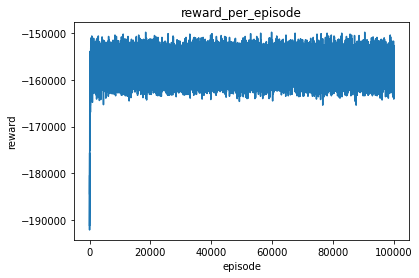

<Figure size 432x288 with 0 Axes>

In [ ]:
  plt.plot(reward_per_episode)
  plt.title("reward_per_episode")
  plt.xlabel('episode')
  plt.ylabel('reward')
  plt.show()
  plt.savefig('rewards2-per-episode.png')

In [ ]:
policy

In [ ]:
np.savetxt('reward-per-episode', reward_per_episode, fmt='%s', delimiter = ',' )

In [ ]:
# Writing nested dictionary to csv
import csv
import itertools
field_names= ['state', 0,1,2,3,4,5,6,7]
with open('Sample_counts.csv', 'w') as csvfile:
  writer = csv.DictWriter(csvfile, field_names)
  for key, val in sample_counts.items():
    row = {'state': key}
    row.update(val)
    writer.writerow(row)

In [ ]:
# Writing nested dictionary to csv
import csv
import itertools
field_names= ['state', 0,1,2,3,4,5,6,7]
with open('Q.csv', 'w') as csvfile:
  writer = csv.DictWriter(csvfile, field_names)
  for key, val in Q.items():
    row = {'state': key}
    row.update(val)
    writer.writerow(row)

In [ ]:
policy_view = policy.items()
policy_list = list(policy_view)
policy_list

In [ ]:
np.savetxt('policy-list.csv', policy_list, fmt='%s', delimiter=',')

In [ ]:
V_view = V.items()
V_list = list(V_view)
V_list

In [ ]:
np.savetxt('V_list.csv', V_list, fmt='%s', delimiter=',')

In [ ]:
# transitionprobs_view = transition_probs.items()
# transitionprobs_list = list(transitionprobs_view)
# transitionprobs_list

In [ ]:
# np.savetxt('transitionprobs-list.csv', transitionprobs_list, fmt='%s', delimiter=',')

LET'S BEGIN SIMULATION....


*   Seperate Simulation programs for were created for the three policies below - The major change to the programs are the policies used.
*   A modified planner class helper function named standard_planner_sim() was created for the simulation. It collects info about the number of preventive and corrective maintenance carried out in each iteration.



In [ ]:
# AI-Based Maintenance Planner Environment for Simulation
import numpy as np

# "NM" = No Maintenance, "PM" = Preventive Maintenance
ACTION_SPACE = ('NM', 'PM')

class Planner: # Environment for 3 machines
  def __init__(self, start=(0,0,0)):
    self.s = start

  def set(self, rewards, actions):
    # rewards should be a dict of: ("action"): r ("NM"): reward
    # actions should be a dict of: (int): A (1): list of actions for all 3 machines
    self.rewards = rewards
    self.actions = actions
    # self.PM_counts = PM_counts

  # Use to set next state to current state
  def set_state(self, s):
    self.s = tuple(s)

  def current_state(self):
    return (self.s)

  def is_terminal(self):  #Takes tuple of states for all machines, Returns a boolean tuple
    status = []
    for t in range(3):
      status.append(self.s[t] >= 5)
      
    return(status)

  def is_terminal_single(self, s):  # Takes single machine state, Returns a boolean 
    return s >= 5

  def reset(self):
    # put agent back in start position
    self.s = (0,0,0)
    return (self.s)

  def get_next_state(self,a):
    # This answers: where would I end up if I perform action 'a' in state 's'?
    s_next = [0,0,0]

    for m in range(3):
      # Check if state is terminal
      # When in terminal state, the next state is independent of the action taken
      if self.is_terminal_single(self.s[m]):
        s_next[m] = 0
        # Debugging tool
        print("episode end:", m, self.s[m], s_next[m], a[m])
      else:
        print("Not terminal state:", m, self.s[m], s_next[m], a[m])
      
      if a[m] == "NM":
        if (self.is_terminal_single(self.s[m]) == 0):
          s_next[m] = np.random.choice([self.s[m] + 1, 0], p=[transition_probs[m,self.s[m],a[m]], 1-transition_probs[m,self.s[m],a[m]]])
          # Debugging 
          print("Action is AM:", m, self.s[m], s_next[m], a[m])

      if a[m] == "PM":
        s_next[m] = 0
        # Debugging
        print("action is PM:", m, self.s[m], s_next[m], a[m])
    
    # Set next state as new state
    self.set_state(s_next)
    return s_next

  def act(self, a):
    a_array = np.copy(a)
    reward = np.zeros((3,))
    PM_counts = np.zeros((3,))
    CM_counts = np.zeros((3,))

    # this answers: where would I end up if I perform action 'a' in state 's'?
    s_next = np.zeros((3,))
    for m in range(3):
      # Check if state is terminal
      if self.is_terminal_single(self.s[m]):
        s_next[m] = 0
        a_array[m] = "CM"
        CM_counts[m] = 1

      if a[m] == "NM":
        if (self.is_terminal_single(self.s[m]) == 0):
          s_next[m] = np.random.choice([self.s[m] + 1, 0], p=[transition_probs[m,self.s[m],a[m]], 1-transition_probs[m,self.s[m],a[m]]])
          if s_next[m] == 0:
            a_array[m] = "CM"
            CM_counts[m] = 1
            

      if a[m] == "PM":
        s_next[m] = 0
        PM_counts[m] = 1

      # Collect reward for action taken on each machine
      reward[m] = self.rewards[a_array[m]]

       

    # Set next state as new state
    self.set_state(s_next)
    return reward.sum(), PM_counts, CM_counts

def standard_planner_sim():
  # define a planner that describes the reward for arriving at each state
  # and possible actions at each state
  # s means start position
  g = Planner()
  rewards = {("NM"): 0, ("PM"): -100, ("CM"): -500}
  actions = {
    (0): ('NM', 'NM', 'NM'),
    (1): ('PM', 'PM', 'PM'),
    (2): ('NM', 'NM', 'PM'),
    (3): ('NM', 'PM', 'NM'),
    (4): ('PM', 'NM', 'NM'),
    (5): ('PM', 'PM', 'NM'),
    (6): ('PM', 'NM', 'PM'),
    (7): ('NM', 'PM', 'PM'),
  }
  g.set(rewards, actions)
  return g

In [ ]:
# Q-Learning Simulation / Agent Play
if __name__ == '__main__':
  # planner = standard_planner()
  planner = standard_planner_sim()

  # repeat until convergence
  reward_per_episode = []
  # Create lists to store PMs and CMs/episode: These will be a list of lists (3 machines/episode)
  PM_counts_per_episode = []
  CM_counts_per_episode = []

  for it in range(1000):
    if it % 200 == 0:
      print("it:", it)

    # begin a new episode
    s = planner.reset()
    episode_reward = 0
    episode_PM_counts = np.zeros((3,))
    episode_CM_counts = np.zeros((3,))

    for i in range(100):
      # perform action and get next state + reward
      a = policy[s]
      # print(a)
      r, PM_counts_per_timestep, CM_counts_per_timestep = planner.act(planner.actions[a])
      s2 = planner.current_state()

      # update reward
      episode_reward += r

      # From the envir returns a list of PMs/timestep, which we can update
      # Update PM_counts
      episode_PM_counts += PM_counts_per_timestep 

      episode_CM_counts += CM_counts_per_timestep 

      # next state becomes current state
      s = s2
    
    # log the reward for this episode
    reward_per_episode.append(episode_reward)


    # log PM/s per episode
    PM_counts_per_episode.append(episode_PM_counts)
    CM_counts_per_episode.append(episode_CM_counts)


it: 0
it: 200
it: 400
it: 600
it: 800


In [ ]:
# Periodic Maintenance Simulation
# Policy function
def periodic_policy(i):
  if (((i+1) % 3 == 0) & (i != 0)):
    policy = 1
  else:
    policy = 0
  return policy

if __name__ == '__main__':
  # planner = standard_planner()
  planner = standard_planner_sim()

  # repeat until convergence
  reward_per_episode = []
  # Create lists to store PMs and CMs/episode: These will be a list of lists (3 machines/episode)
  PM_counts_per_episode = []
  CM_counts_per_episode = []

  for it in range(1000):
    if it % 200 == 0:
      print("it:", it)

    # begin a new episode
    s = planner.reset()
    episode_reward = 0
    episode_PM_counts = np.zeros((3,))
    episode_CM_counts = np.zeros((3,))

    for i in range(100):
      # perform action and get next state + reward
      a = periodic_policy(i)
      # print(a)
      r, PM_counts_per_timestep, CM_counts_per_timestep = planner.act(planner.actions[a])
      s2 = planner.current_state()

      # update reward
      episode_reward += r

      # From the envir returns a list of PMs/timestep, which we can update
      # Update PM_counts
      episode_PM_counts += PM_counts_per_timestep 

      episode_CM_counts += CM_counts_per_timestep 

      # next state becomes current state
      s = s2
    
    # log the reward for this episode
    reward_per_episode.append(episode_reward)


    # log PM/s per episode
    PM_counts_per_episode.append(episode_PM_counts)
    CM_counts_per_episode.append(episode_CM_counts)


it: 0
it: 200
it: 400
it: 600
it: 800


In [ ]:
# Corrective Maintenance Policy
if __name__ == '__main__':
  # planner = standard_planner()
  planner = standard_planner_sim()

  # repeat until convergence
  reward_per_episode = []
  # Create lists to store PMs and CMs/episode: These will be a list of lists (3 machines/episode)
  PM_counts_per_episode = []
  CM_counts_per_episode = []

  for it in range(1000):
    if it % 200 == 0:
      print("it:", it)

    # begin a new episode
    s = planner.reset()
    episode_reward = 0
    episode_PM_counts = np.zeros((3,))
    episode_CM_counts = np.zeros((3,))

    for i in range(100):
      # perform action and get next state + reward
      a = 0
      r, PM_counts_per_timestep, CM_counts_per_timestep = planner.act(planner.actions[a])
      s2 = planner.current_state()

      # update reward
      episode_reward += r

      # From the envir returns a list of PMs/timestep, which we can update
      # Update PM_counts
      episode_PM_counts += PM_counts_per_timestep 

      episode_CM_counts += CM_counts_per_timestep 

      # next state becomes current state
      s = s2
    
    # log the reward for this episode
    reward_per_episode.append(episode_reward)


    # log PM/s per episode
    PM_counts_per_episode.append(episode_PM_counts)
    CM_counts_per_episode.append(episode_CM_counts)


it: 0
it: 200
it: 400
it: 600
it: 800


Collect relevant Info from simulation

In [ ]:
maintenance_cost_per_episode = -np.array(reward_per_episode)

In [ ]:
maintenance_cost_per_episode

In [ ]:
reward_per_episode = np.array(reward_per_episode)

In [ ]:
reward_per_episode

In [ ]:
PM_counts_per_episode = np.array(PM_counts_per_episode)

In [ ]:
PM_counts_per_episode

In [ ]:
CM_counts_per_episode = np.array(CM_counts_per_episode)

In [ ]:
CM_counts_per_episode

In [ ]:
average_maintenance_cost = np.mean(maintenance_cost_per_episode)

In [ ]:
average_maintenance_cost

In [ ]:
average_CM_counts_per_machine = np.mean(np.array(CM_counts_per_episode), axis=0)

In [ ]:
average_CM_counts_per_machine

array([0., 0., 0.])

In [ ]:
average_PM_counts_per_machine = np.mean(np.array(PM_counts_per_episode), axis=0)
average_PM_counts_per_machine

array([50., 50., 50.])

Save Info

In [ ]:
np.savetxt('RL-maintenance-sim-PM-counts-per-episode', PM_counts_per_episode, fmt='%s', delimiter = ',')

In [ ]:
np.savetxt('RL-maintenance-sim-CM-counts-per-episode', CM_counts_per_episode, fmt='%s', delimiter = ',')

In [ ]:
np.savetxt('RL-maintenance-sim-reward-per-episode', reward_per_episode, fmt='%s', delimiter = ',')

In [ ]:
np.savetxt('RL-maintenance-sim-cost-per-episode', maintenance_cost_per_episode, fmt='%s', delimiter = ',')

In [ ]:
np.savetxt('RL-maintenance-sim-cumresults', (average_maintenance_cost, average_CM_counts_per_machine, average_PM_counts_per_machine), fmt='%s', delimiter = ',' )

Let's Plot some figures - total maintenance cost per episode for all three(3) policies

In [ ]:
RL_cost_per_episode = -np.array(reward_per_episode)

In [ ]:
periodic_cost_per_episode = -np.array(reward_per_episode)

In [ ]:
corrective_cost_per_episode = -np.array(reward_per_episode)

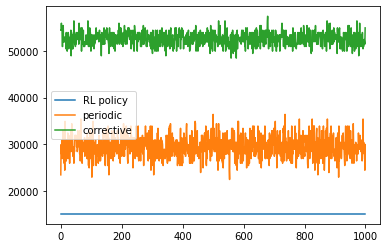

In [ ]:
plt.plot(RL_cost_per_episode, label='RL policy')
plt.plot(periodic_cost_per_episode, label = 'periodic')
plt.plot(corrective_cost_per_episode, label = 'corrective')
# plt.title("maintenance cost per episode")
# plt.xlabel('episode')
# plt.ylabel('costs')
plt.legend()
plt.savefig('maintenancecosts-per-episode.png', dpi=200)